# Episodic Lunar Lander with function appoximation and control

This Notebook is intended to solve the Episodic Lunar Lander problem using Semi-gradient Expected sarsa with neural networks for function approximation.

The description of the problem is given below:

"Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine." 

<img src="./assets/lunar_lander.png" width="380" />

Image and Text taken from [Official documentaiton Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy

import gym
from gym.wrappers import Monitor
from utils import *

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Markov Decision Process 

As a quick recap, the diagram below explains the workflow of a Markov Decision Process (MDP)

<img src="./assets/MDP.png" width="380" />

Image taken from [Section 3.1 Reinforment Learning an Introduction](http://www.incompleteideas.net/book/RLbook2018.pdf#page=70)

## Environment and Agent specifications

The states, actions, reward and termination are given as follows for the lunar lander problem.

**Observation**: 

     Type:  Box(8)
     Num    Observation                           Min            Max
     0      X position                            -inf           inf
     1      Y position                            -inf           inf
     2      X velocity                            -inf           inf
     3      Y velocity                            -inf           inf
     4      Theta w.r.t ground                    -inf           inf
     5      Theta rate                            -inf           inf
     6      1 if first leg has contact, else 0    -inf           inf
     7      1 if second leg has contact, else 0   -inf           inf
         
**Actions**:

     Type: Discrete(4)
     Num    Action
     0      Do nothing
     1      Fire left engine
     2      Fire main engine
     3      Fire right engine

        
**Reward**:

     Reward of 0 is awarded if the agent reached the flag(position = 0.5) on top of the mountain
     Reward of -1 is awarded if the position of the agent is less than 0.5
     Reward of -100 for flying off the screen
     Reward of +100 for successful landing
     Reward of -0.3 for firing main thrusters
     Reward of -0.03 for firing side thrusters
     Reward of +10 for each leg touching fround
        
**Starting State**:

     The starting position is above the landing target
        
**Episode Termination**:

     The lander crashes
     The lander comes to rest
     Episode length is greater than 200
     
For further information see [Github source code](https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py).

The next cell aims to show how to iterate with the action and observation space of the agent and extract relevant information from it

In [3]:
env = gym.make("LunarLander-v2")
observation = env.reset() 

# Object's type in the action Space
print("The Action Space is an object of type: {0}\n".format(env.action_space))
# Shape of the action Space
print("The shape of the action space is: {0}\n".format(env.action_space.n))
# Object's type in the Observation Space
print("The Environment Space is an object of type: {0}\n".format(env.observation_space))
# Shape of the observation space
print("The Shape of the dimension Space are: {0}\n".format(env.observation_space.shape))
# The high and low values in the observation space
print("The High values in the observation space are {0}, the low values are {1}\n".format(
    env.observation_space.high, env.observation_space.low))
# Example of observation
print("The Observations at a given timestep are {0}\n".format(env.observation_space.sample()))

The Action Space is an object of type: Discrete(4)

The shape of the action space is: 4

The Environment Space is an object of type: Box(8,)

The Shape of the dimension Space are: (8,)

The High values in the observation space are [inf inf inf inf inf inf inf inf], the low values are [-inf -inf -inf -inf -inf -inf -inf -inf]

The Observations at a given timestep are [-1.3609413  -0.81943125  0.00691082  0.965331   -1.3784901   1.0290705
 -1.7937465   0.85192055]



## Computing action-values with neural networks

To compute action-values, a feed-forward neural network is used. This apporach allows us to compute action-values using the weights of the neural network.

$$ q_\pi(s) \approx \hat{q}(s, a, w) = NN(s,a,w) $$

Neural networks are used to solve the control problem in RL, particularly, this networl is going to be used with an Episodic Semi-gradient Expected Sarsa agent. The inputs of the network are the states, which in this case are eight, the number of hidden layers and hidden units can vary. Finally, the number of inputs is equals to the number of actions in the problem, therefore, four output nodes are needed in the final layer. Each output node corresponds to the action value of a particular action.

<img src="./assets/nn.png" width="320" />


For further information about Neural Networks for function approximation see [Section 9.7 of Reinforment Learning an Introduction](http://www.incompleteideas.net/book/RLbook2018.pdf#page=246)

Image taken from [Reinforcement learning specialization, C4L5S1](https://www.coursera.org/learn/complete-reinforcement-learning-system/lecture/CVH40/meeting-with-adam-getting-the-agent-details-right)

In [4]:
# Neural Netork to compute action values
class ActionValueNetwork(nn.Module):
    # Work Required: Yes. Fill in the layer_sizes member variable (~1 Line).
    def __init__(self, network_config):
        super().__init__()
        
        # Number of states
        self.state_dim = network_config.get("state_dim")
        # Hidden units
        self.num_hidden_units = network_config.get("num_hidden_units")
        # Actions or output units
        self.num_actions = network_config.get("num_actions")
        
        # Initialzie hidden layer 
        self.hidden = nn.Linear(self.state_dim, self.num_hidden_units)
        # Initialize output layer
        self.output = nn.Linear(self.num_hidden_units, self.num_actions)
                
    
    def forward(self, s):
        """
        This is a feed-forward pass in the network
        Args:
            s (Numpy array): The state, a 2D array of shape (batch_size, state_dim)
        Returns:
            The action-values (Torch array) calculated using the network's weights.
            A 2D array of shape (batch_size, num_actions)
        """
        # Transform observations into a pytorch tensor
        s = torch.Tensor(s)
        
        q_vals = F.relu(self.hidden(s))
        q_vals = self.output(q_vals)

        return q_vals

## Replay Buffer

Experience replay is a technique very similar to planning in RL. Overall, this technique is used to update the action-values of the agent with a set of "experience" collected in a model. This experience allows the model to learn without interacting with the environment using simulated experience.

Experience replay is a simple method that can get some of the advantages of planning by saving a buffer of experience and using the data stored in the buffer as a model. This view of prior data as a model works because the data represents actual transitions from the underlying MDP. The data stored in the model are the state, action, reward and next state. 

The model will be filled until a queue size is reached, only then the model will drop its oldest observation and add a new one. With this buffer of information, it is possible to sample "batches" and update the action values of the agent.

As a quick recap, the next pseudocode shows the pseudocode for Dyna-Q algorithm where the agent performs planning steps, improving the learning process of the agent with simulated experience.

<img src="./assets/dyna-q.png" width="480" />

The planning process is given in the next image.

<img src="./assets/planning.png" width="320" />

For further information about planning see [Section 8.2 of Reinforment Learning an Introduction](http://www.incompleteideas.net/book/RLbook2018.pdf#page=185). **Note**: Images taken from the last reference.


In [5]:
class ReplayBuffer:
    def __init__(self, size, minibatch_size):
        """
        Args:
            size (integer): The size of the replay buffer.              
            minibatch_size (integer): The sample size.
        """
        # Create the buffer
        self.buffer = [] 
        self.minibatch_size = minibatch_size
        self.max_size = size

    def append(self, state, action, reward, terminal, next_state):
        """
        Args:
            state (Numpy array): The state of size (state_dim)            
            action (integer): The action.
            reward (float): The reward.
            terminal (integer): 1 if the next state is a terminal state and 0 otherwise.
            next_state (Numpy array): The next state of size (state_dim) .           
        """
        if len(self.buffer) == self.max_size:
            # Delete first position of the buffer if the Queue size is equals to max size
            del self.buffer[0]
        # Append new step
        self.buffer.append([state, action, reward, terminal, next_state])

    def sample(self):
        """
        Returns:
            A list of transition tuples including state, action, reward, terinal, and next_state
            The return of this function is of size (minibatch_size)
        """
        idxs = np.random.choice(np.arange(len(self.buffer)), size=self.minibatch_size)
        return [self.buffer[idx] for idx in idxs]

    def size(self):
        return len(self.buffer)

## Softmax Policy

To compute the actions, a softmax policy is used. One advantage of a softmax policy is that it explores according to the action-values, meaning that an action with a moderate value has a higher chance of getting selected compared to an action with a lower value. This sort of policies provides a feasible alternative to do exploration.

The probability of selecting each action according to the softmax policy is shown below:

$$Pr{(A_t=a | S_t=s)} \hspace{0.1cm} \dot{=} \hspace{0.1cm} \frac{e^{Q(s, a)/\tau}}{\sum_{b \in A}e^{Q(s, b)/\tau}}$$

Here, $\tau$ is the temperature parameter which controls how much the agent focuses on the highest valued actions. The smaller the temperature, the more the agent selects the greedy action. Conversely, when the temperature is high, the agent selects among actions more uniformly random.

Given that a softmax policy exponentiates action values, if those values are large, exponentiating them could get very large. To implement the softmax policy in a numerically stable way,the maximum action-value is substracted from the action-values. Doing so, the probability of selecting each action looks as follows:

$$Pr{(A_t=a | S_t=s)} \hspace{0.1cm} \dot{=} \hspace{0.1cm} \frac{e^{Q(s, a)/\tau - max_{c}Q(s, c)/\tau}}{\sum_{b \in A}e^{Q(s, b)/\tau - max_{c}Q(s, c)/\tau}}$$

Recall that changing the action preferences (action-values in this case) for a constant, would not change the final value of the softmax probability. This Softmax implementation is different than the one provided by Pytorch.

For further informartion about Softmax policies and action preferences see [Section 13.1 of Reinforment Learning an Introduction](http://www.incompleteideas.net/book/RLbook2018.pdf#page=344)


In [6]:
def softmax(action_values, tau=1.0):
    """
    Args:
        action_values (Tensor array): A 2D array of shape (batch_size, num_actions). 
                       The action-values computed by an action-value network.              
        tau (float): The temperature parameter scalar.
    Returns:
        A 2D Tensor array of shape (batch_size, num_actions). Where each column is a probability distribution 
        over the actions representing the policy.
    """
    
    # Compute the preferences
    preferences = action_values / tau
    # Compute the maximum preference across the actions (Max action per row or batch)
    max_preference = torch.max(preferences, dim = 1)[0]

    # Reshape max_preference  to [Batch, 1] 
    reshaped_max_preference = max_preference.view((-1, 1))
    
    # Computing numerator
    exp_preferences = torch.exp(preferences - reshaped_max_preference)
    # Computing the denominator suming over rows (batches).
    sum_of_exp_preferences = torch.sum(exp_preferences, dim = 1)
    
    # Reshape sum_of_exp_preferences array to [Batch, 1] 
    reshaped_sum_of_exp_preferences = sum_of_exp_preferences.view((-1, 1))
    
    # Computing action probabilities
    action_probs = exp_preferences / reshaped_sum_of_exp_preferences
    action_probs = action_probs.squeeze()
    
    return action_probs

In [7]:
# Testing the Softmax implementation
rand_generator = np.random.RandomState(0)
action_values = torch.tensor(rand_generator.normal(0, 1, (2, 4)))
tau = 0.5

action_probs = softmax(action_values, tau)
print("action_probs", action_probs)

assert(np.allclose(action_probs, np.array([
    [0.25849645, 0.01689625, 0.05374514, 0.67086216],
    [0.84699852, 0.00286345, 0.13520063, 0.01493741]
])))


action_probs tensor([[0.2585, 0.0169, 0.0537, 0.6709],
        [0.8470, 0.0029, 0.1352, 0.0149]], dtype=torch.float64)


## Computing TD target and TD estimate

The TD target and TD estimate's computation will be done in the next lines. The main idea here is to obtain the action-value network updates with experience sampled from the experience replay buffer.

At time $t$, there is an action-value function represented as a neural network, say $Q_t$. The idea is to update the action-value function and get a new one we can use at the next timestep. We will get this $Q_{t+1}$ using multiple replay steps that each result in an intermediate action-value function $Q_{t+1}^{i}$ where $i$ indexes which replay step we are at.

In each replay step, we sample a batch of experiences from the replay buffer and compute a minibatch Expected-SARSA update. Across these N replay steps, we will use the current "un-updated" action-value network at time $t$, $Q_t$, for computing the action-values of the next-states. This contrasts using the most recent action-values from the last replay step $Q_{t+1}^{i}$. We make this choice to have targets that are stable across replay steps. Here is the pseudocode for performing the updates:

$$
\begin{align}
& Q_t \leftarrow \text{action-value network at timestep t (current action-value network)}\\
& \text{Initialize } Q_{t+1}^1 \leftarrow Q_t\\
& \text{For } i \text{ in } [1, ..., N] \text{ (i.e. N} \text{  replay steps)}:\\
& \hspace{1cm} s, a, r, t, s'
\leftarrow \text{Sample batch of experiences from experience replay buffer} \\
& \hspace{1cm} \text{Do Expected Sarsa update with } Q_t: Q_{t+1}^{i+1}(s, a) \leftarrow Q_{t+1}^{i}(s, a) + \alpha \cdot \left[r + \gamma \left(\sum_{b} \pi(b | s') Q_t(s', b)\right) - Q_{t+1}^{i}(s, a)\right]\\
& \hspace{1.5cm} \text{ making sure to add the } \gamma \left(\sum_{b} \pi(b | s') Q_t(s', b)\right) \text{ for non-terminal transitions only.} \\
& \text{After N replay steps, we set } Q_{t+1}^{N} \text{ as } Q_{t+1} \text{ and have a new } Q_{t+1} \text{for time step } t + 1 \text{ that we will fix in the next set of updates. }
\end{align}
$$

As you can see in the pseudocode, after sampling a batch of experiences, we do many computations. The basic idea however is that we are looking to compute a form of a TD error. 

$$ R_{t+1} + \gamma \hat{q}(S_{t+1}, A_{t+1}, w)- \hat{q}(S_t, A_t, w) $$
 
Recall that the for this problem, the TD Target is given by.

$$ r + \gamma \left(\sum_{b} \pi(b | s') Q_t(s', b)\right) $$

Similarly, the TD estimate is.

$$ Q_{t+1}^{i}(s, a) $$

The Semi-gradient Expected Sarsa update is given below.

$$w \leftarrow w + \alpha[R_{t+1} + \gamma \sum_{a'}\pi(a' | S_{t+1}) \hat{q}(S_{t+1}, a', w) - \hat{q}(S_t, A_t, w)]\nabla \hat{q}(S_t, A_t, w)$$


For further explanation about Episodic semi-gradient control see [Section 10.1 of Reinforment Learning an Introduction](http://www.incompleteideas.net/book/RLbook2018.pdf#page=265z)


In [8]:
# Method to compute the TD Target and TD estimate
def get_td(states, next_states, actions, rewards, discount, terminals, network, current_q, tau):
    """
    Args:
        states (Numpy array): The batch of states with the shape (batch_size, state_dim).
        next_states (Numpy array): The batch of next states with the shape (batch_size, state_dim).
        actions (Numpy array): The batch of actions with the shape (batch_size,).
        rewards (Numpy array): The batch of rewards with the shape (batch_size,).
        discount (float): The discount factor (gamma).
        terminals (Numpy array): The batch of terminals with the shape (batch_size,).
        network (ActionValueNetwork): The latest state of the network that is getting replay updates.
        current_q (ActionValueNetwork): The fixed network used for computing the targets, 
                                        and particularly, the action-values at the next-states.
    Returns:
        target_vec (Tensor array): The TD Target for actions taken, of shape (batch_size,)
        estimate_vec (Tensor array): The TD estimate for actions taken, of shape (batch_size,)
    """
    
    # network is the latest state of the network that is getting replay updates. In other words, 
    # network represents Q_{t+1}^{i} whereas current_q represents Q_t, the fixed network used 
    # for computing the  targets, and particularly, the action-values at the next-states.
    
    # q_next_mat is a 2D Tensor of shape (batch_size, num_actions)
    # used to compute the action-values of the next states
    # Detach is used to remove this graph from the main graph
    q_next_mat = current_q.forward(next_states).detach()
    
    # Compute policy at next state. 
    # probs_mat is a 2D Tensor of shape (batch_size, num_actions)
    probs_mat = softmax(q_next_mat, tau)
    
    # Sum of the action-values for the next_states weighted by the policy, probs_mat.
    # (1 - terminals) to make sure v_next_vec is zero for terminal next states.
    # v_next_vec is a 1D Tensor of shape (batch_size,)
    v_next_vec = torch.zeros((q_next_mat.shape[0]), dtype=torch.float64).detach()
    # Sum over rows axis (batches)
    v_next_vec = torch.sum(probs_mat * q_next_mat, dim = 1) * (1 - torch.tensor(terminals))    
    
    # Compute Expected Sarsa target
    # target_vec is a 1D Tensor of shape (batch_size,)
    target_vec = torch.tensor(rewards) + (discount * v_next_vec)
    
    # Computing action values at the current states for all actions using network
    # q_mat is a 2D Tensor of shape (batch_size, num_actions)
    q_mat = network.forward(states)
    
    # Batch Indices is an array from 0 to the batch size - 1. 
    batch_indices = torch.arange(q_mat.shape[0])

    # Compute q_vec by selecting q(s, a) from q_mat for taken actions
    # q_vec are the estimates
    # q_vec is a 1D Tensor of shape (batch_size)
    estimate_vec = q_mat[batch_indices, actions]  

    return target_vec, estimate_vec

## Computing Network's optmizer

One important step is to optimize the network using the TD estimate and the TD target computed previously. As a quick recap, the Mean squared value error is given below.

$$\overline{VE} = \sum_s\mu(s)[V_\pi(s) - \hat{v}(s,w)]^2$$

The idea is to use $\overline{VE}$ as the Loss function to optimize the action-value network. For this particular problem, the MSE implementation provided by Pytorch is used. Additionally, the Adam optimizer is used to optimize the weights of the neural network.

See [Section 9.2 of Reinforment Learning an Introduction](http://www.incompleteideas.net/book/RLbook2018.pdf#page=221)

In [9]:
### Work Required: Yes. Fill in code in optimize_network (~2 Lines).
def optimize_network(experiences, discount, optimizer, network, current_q, tau, criterion):
    """
    Args:
        experiences (Numpy array): The batch of experiences including the states, actions, 
                                   rewards, terminals, and next_states.
        discount (float): The discount factor.
        network (ActionValueNetwork): The latest state of the network that is getting replay updates.
        current_q (ActionValueNetwork): The fixed network used for computing the targets, 
                                        and particularly, the action-values at the next-states.
    Return:
        Loss (float): The loss value for the current batch.
    """
    
    # Get states, action, rewards, terminals, and next_states from experiences
    states, actions, rewards, terminals, next_states = map(list, zip(*experiences))
    states = np.concatenate(states) # Batch per states
    next_states = np.concatenate(next_states) # Batch per states
    rewards = np.array(rewards) # Batch size
    terminals = np.array(terminals) # Batch size
    batch_size = states.shape[0] # Batch size
    
    # Computing TD target and estimate using get_td function
    td_target, td_estimate = get_td(states, next_states, actions, rewards, discount, terminals, \
                                          network, current_q, tau)
    
    # zero the gradients buffer
    optimizer.zero_grad()
    # Compute the  Mean squared value error loss
    loss = criterion(td_estimate.double().to(device), td_target.to(device))
    # Backprop the error
    loss.backward()
    # Optimize the network
    optimizer.step()
    
    return (loss / batch_size).detach().numpy()

## Implementing Expected-Sarsa Agent

The final step is to use all the methods implemented above in the Expected-Sarsa Agent.

In [10]:
### Expected Expected-Sarsa Agent
class ExpectedSarsaAgent():
    def __init__(self):
        self.name = "expected_sarsa_agent"
        
    def agent_init(self, agent_config):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the agent.

        Assume agent_config dict contains:
        {
            network_config: dictionary,
            optimizer_config: dictionary,
            replay_buffer_size: integer,
            minibatch_sz: integer, 
            num_replay_updates_per_step: float
            discount_factor: float,
        }
        """
        self.replay_buffer = ReplayBuffer(agent_config['replay_buffer_size'], 
                                          agent_config['minibatch_sz'])
        # Add model to CPU or GPU respectively
        self.network = ActionValueNetwork(agent_config['network_config']).to(device)
        self.optimizer = optim.Adam(self.network.parameters(), lr = agent_config['optimizer_config']['step_size'], 
                                    betas=(agent_config['optimizer_config']['beta_m'], agent_config['optimizer_config']['beta_v']),
                                    eps=agent_config['optimizer_config']['epsilon']) 
        self.criterion = nn.MSELoss()
        self.num_actions = agent_config['network_config']['num_actions']
        self.num_replay = agent_config['num_replay_updates_per_step']
        self.discount = agent_config['gamma']
        self.tau = agent_config['tau']
                
        self.last_state = None
        self.last_action = None
        
        self.sum_rewards = 0
        self.episode_steps = 0
        self.loss = 0

    def policy(self, state):
        """
        Args:
            state (Numpy array): the state.
        Returns:
            the action. 
        """
        action_values = self.network.forward(state)
        probs_batch = softmax(action_values, self.tau).detach().numpy()
        action = np.random.choice(self.num_actions, p=probs_batch.squeeze())
        return action

    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        self.sum_rewards = 0
        self.episode_steps = 0
        self.last_state = np.array([state])
        self.last_action = self.policy(self.last_state)
        return self.last_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        
        # Add current reward to the sum of rewards
        self.sum_rewards += reward
        self.episode_steps += 1

        # Make state an array of shape (1, state_dim) to add a batch dimension and
        # to later match the forward() and get_td() functions
        state = np.array([state])

        # Select action
        action = self.policy(state) #change for state for submission, normally, it is self.last_state
        
        # Append new experience to replay buffer
        self.replay_buffer.append(self.last_state, self.last_action, reward, 0, state)
        
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            # Make a copy of the current network to obtain stable targets
            current_q = deepcopy(self.network)
            for _ in range(self.num_replay):                
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                
                # Call optimize_network to update the weights of the network 
                self.loss +=optimize_network(experiences, self.discount, self.optimizer, self.network, current_q, self.tau,
                                 self.criterion)
                
        # Update the last state and last action.
        self.last_state = state
        self.last_action = action
        
        return self.last_action

    # update of the weights using optimize_network 
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        self.sum_rewards += reward
        self.episode_steps += 1
        
        # Set terminal state to an array of zeros
        state = np.zeros_like(self.last_state)

        self.replay_buffer.append(self.last_state, self.last_action, reward, 1, state)
        
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            current_q = deepcopy(self.network)
            for _ in range(self.num_replay):
                
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                
                # Call optimize_network to update the weights of the network
                self.loss += optimize_network(experiences, self.discount, self.optimizer, self.network, current_q, self.tau,
                                 self.criterion)
                
        
    def agent_message(self, message):
        if message == "get_sum_reward":
            return self.sum_rewards, self.episode_steps
        else:
            raise Exception("Unrecognized Message!")


## Running the experiment

The following lines solves the Lunar Lander problem and plot the average reward obtained over episodes, steps taken to solve the challenge at a specific episode and average loss over episodes.

In [11]:
# Test the expected Sarsa Agent 
#model = ActionValueNetwork(network_config).to(device)
num_runs = 1
num_episodes = 1000

# Experiment parameters
agent_info = {
             'network_config': {
                 'state_dim': env.observation_space.shape[0],
                 'num_hidden_units': 256,
                 'num_actions': env.action_space.n
             },
             'optimizer_config': {
                 'step_size': 1e-3, 
                 'beta_m': 0.9, 
                 'beta_v': 0.999,
                 'epsilon': 1e-8
             },
             'replay_buffer_size': 50000,
             'minibatch_sz': 8,
             'num_replay_updates_per_step': 4,
             'gamma': 0.99,
             'tau': 0.001}

# Variable to store the amount of steps taken to solve the challeng
all_steps = []
# Variable to save the rewards in an episode
all_rewards = []
all_loss = []

# Agent
agent = ExpectedSarsaAgent()

# Environment
env = gym.make('LunarLander-v2')
env.reset()
# Maximum number of possible iterations (default was 200)
env._max_episode_steps = 10000

# Number of runs are the times the experiment will start again (a.k.a episode)
for n_runs in range(num_runs):
    
    # Resets environment
    observation = env.reset()
    # Reset agent
    agent.agent_init(agent_info)
    # Generate last state and action in the agent
    last_action = agent.agent_start(observation)
    # Steps, rewards and loss at each episode to solve the challenge
    steps_per_episode = []
    rewards_per_episode = []
    loss_per_episode = []
        
    # Times the environment will start again without resetting the agent
    for t in tqdm(range(num_episodes)):
        
        # Reset done flag
        done = False
        # Set rewards, steps and loss to zero
        rewards = 0
        n_steps = 0
        agent.loss = 0
        # Reset environment
        observation = env.reset()
        # Run until the experiment is over
        while not done:
            
            # Render the environment only after t > # episodes
            if t > 300:
                env.render()

            # Take a step with the environment
            observation, reward, done, info = env.step(last_action)
            
            rewards += reward
            n_steps += 1

            # If the goal has been reached stop
            if done:
                # Last step with the agent
                agent.agent_end(reward)
            else:
                # Take a step with the agent
                last_action = agent.agent_step(reward, observation)
                
        # Append steps taken to solve the episode
        steps_per_episode.append(n_steps)
        # Reward obtained during the episode
        rewards_per_episode.append(rewards)
        # Loss obtained solving the experiment
        loss_per_episode.append(agent.loss)

    # Steps taken to solve the experiment during all
    all_steps.append(np.array(steps_per_episode))
    # Awards obtained during all episode
    all_rewards.append(np.array(rewards_per_episode))
    # Loss obtained during all episodes
    all_loss.append(loss_per_episode)

env.close()

100%|██████████| 1000/1000 [51:03<00:00,  3.06s/it] 


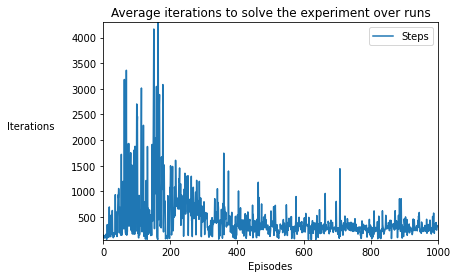

The Minimum number of iterations used to solve the experiment were: 53

The Maximum number of iterations used to solve the experiment were: 4297



In [12]:
steps_average = np.mean(np.array(all_steps), axis=0)
plt.plot(steps_average, label = 'Steps')
plt.xlabel("Episodes")
plt.ylabel("Iterations",rotation=0, labelpad=40)
plt.xlim(-0.2, num_episodes)
plt.ylim(steps_average.min(), steps_average.max())
plt.title("Average iterations to solve the experiment over runs")
plt.legend()
plt.show()
print("The Minimum number of iterations used to solve the experiment were: {0}\n".format(np.array(all_steps).min()))
print("The Maximum number of iterations used to solve the experiment were: {0}\n".format(np.array(all_steps).max()))

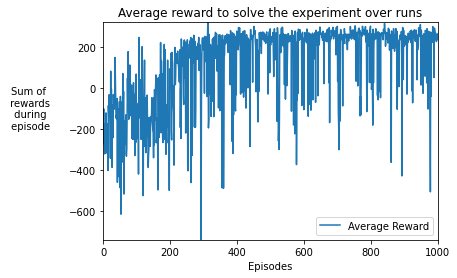

The best reward obtained solving the experiment was: 319.9482722511151

The Worst reward obtained solving the experiment was: -739.7826817464436



In [13]:
rewards_average = np.mean(all_rewards, axis=0)
plt.plot(rewards_average, label = 'Average Reward')
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode" ,rotation=0, labelpad=40)
plt.xlim(-0.2, num_episodes)
plt.ylim(rewards_average.min(), rewards_average.max())
plt.title("Average reward to solve the experiment over runs")
plt.legend()
plt.show()
print("The best reward obtained solving the experiment was: {0}\n".format(np.array(all_rewards).max()))
print("The Worst reward obtained solving the experiment was: {0}\n".format(np.array(all_rewards).min()))

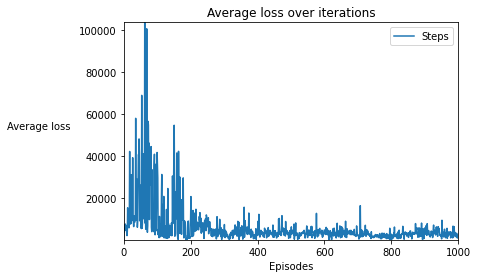

The best loss obtained solving the experiment was: 138.75933101629653

The Worst loss obtained solving the experiment was: 103842.01680098387



In [14]:
loss_average = np.mean(np.array(all_loss), axis=0)
plt.plot(loss_average, label = 'Steps')
plt.xlabel("Episodes")
plt.ylabel("Average loss",rotation=0, labelpad=40)
plt.xlim(-0.2, num_episodes)
plt.ylim(loss_average.min(), loss_average.max())
plt.title("Average loss over iterations")
plt.legend()
plt.show()
print("The best loss obtained solving the experiment was: {0}\n".format(np.array(loss_average).min()))
print("The Worst loss obtained solving the experiment was: {0}\n".format(np.array(loss_average).max()))


## Using the last trained Agent 

This lines shows in a video the performance of the last trained agent and save a video with the results.

In [18]:
# Test Sarsa Agent 
num_runs = 1
num_episodes = 1000

# Environment
env_to_wrap = gym.make('LunarLander-v2')
# Maximum number of possible iterations (default was 200)
env_to_wrap._max_episode_steps = 1500
env = Monitor(env_to_wrap, "./videos/lunarLander", video_callable=lambda episode_id: True, force=True)


# Number of runs are the times the experiment will start again (a.k.a episode)
for n_runs in tqdm(range(num_runs)):
    
    # Resets environment
    observation = env.reset()
    # Generate last state and action in the agent
    last_action = agent.agent_start(observation)
        
    # Times the environment will start again without resetting the agent
    for t in tqdm(range(num_episodes)):

        # View environment
        env.render()
        # Take a step with the environment
        observation, reward, done, info = env.step(last_action)

        # If the goal has been reached stop
        if done:
            # Last step with the agent
            agent.agent_end(reward)
            break
        else:
            # Take a step with the agent
            last_action = agent.agent_step(reward, observation)

env.close()
env_to_wrap.close()

print("Episode finished after {} timesteps".format(t+1))

100%|██████████| 1/1 [00:03<00:00,  3.90s/it]


Episode finished after 261 timesteps
